In [1]:
import lsdb
from lsdb.streams import CatalogStream, InfiniteStream
import numpy as np
import nested_pandas as npd
import dask.dataframe as dd

# LSDB Catalog Streaming

,ra,dec,id,a,b,nested
npartitions=12,,,,,,
"Order: 5, Pixel: 559",double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],"nested<t: [double], flux: [double], band: [str..."
"Order: 5, Pixel: 563",...,...,...,...,...,...
...,...,...,...,...,...,...
"Order: 4, Pixel: 167",...,...,...,...,...,...
"Order: 4, Pixel: 176",...,...,...,...,...,...


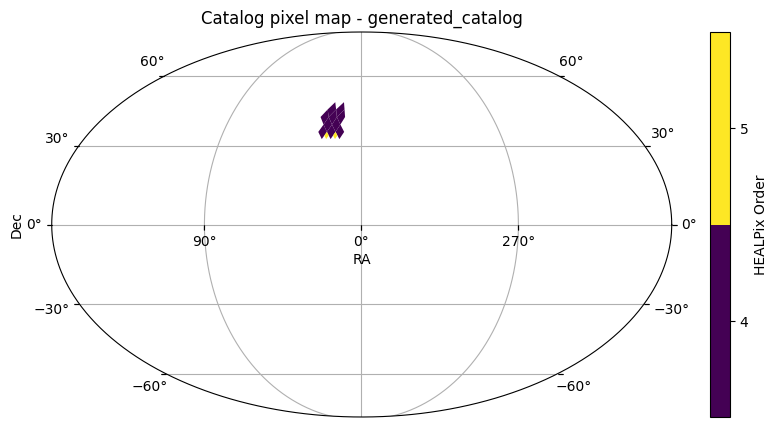

In [3]:
# Create a Toy Catalog for Demo Purposes
cat = lsdb.generate_catalog(500,10, lowest_order=4, ra_range=(15.0,25.0), dec_range=(34.0,44.0), seed=1)
cat.plot_pixels()
cat

## Basic Looping with a CatalogStream

In [ ]:
from lsdb.streams import CatalogStream

# Wraps in a Catalog Object
cat_stream = CatalogStream(cat, seed=1)
cat_stream

In [ ]:
# Allows looping over a catalog, with partitions shuffled before retrieval (by default)
for chunk in cat_stream:
    print(len(chunk)) # return the length of each returned partition

33
75
15
12
14
19
22
78
29
28
76
99


## Alternatively, work with it as an Iterator

In [ ]:
# The CatalogStream implements an iter method
cat_iter = iter(CatalogStream(cat, seed=1))
cat_iter

In [ ]:
# Allows some extra control/visibility
print(f"Number of Partitions Remaining: {len(cat_iter)}")
print(f"Remaining Partition Indices: {cat_iter.partitions_left}")

Number of Partitions Remaining: 11
Remaining Partition Indices: [ 7  5  0  6  8  4  9 10  1  2 11]


In [ ]:
next(cat_iter)

ra        dec    id         a         b  \
_healpix_29                                                          
160810055893234941  20.381433  37.118614  3238   0.68522  0.697975   
160190336778452854  21.488508  35.014465   116  0.728586  0.683906   
...                       ...        ...   ...       ...       ...   
160927011291042898  18.762973  37.515729  2911  0.796589  1.896598   
160965253033726305  20.118216  38.046851    28  0.417022  0.174964   

                                                               nested  
_healpix_29                                                            
160810055893234941  [{t: 8.609436, flux: 68.786653, band: 'g', flu...  
160190336778452854  [{t: 13.792788, flux: 47.106841, band: 'g', fl...  
...                                                               ...  
160927011291042898  [{t: 15.359258, flux: 72.659554, band: 'r', fl...  
160965253033726305  [{t: 6.516199, flux: 65.756793, band: 'g', flu...  

[78 rows x 6 columns]

In [ ]:
print(f"Number of Partitions Remaining: {len(cat_iter.partitions_left)}")
print(f"Remaining Partition Indices: {cat_iter.partitions_left}")

Number of Partitions Remaining: 10
Remaining Partition Indices: [ 7  5  0  6  8  4  9 10  1  2]


## Customizing a CatalogStream

### Fetch Multiple Partitions Per Chunk

> **NOTE:** Be mindful of the increased memory demands of batching multiple partitions, as you'll hold the full batch in memory.

In [ ]:
cat_stream = CatalogStream(catalog=cat, partitions_per_chunk=3, seed=1)
for chunk in cat_stream:
    print(len(chunk))

135
48
196
121


### Choosing Whether to Shuffle

By default, partitions and the rows within partitions are shuffled, but you can also operate without shuffling.

In [ ]:
cat_iter = iter(CatalogStream(catalog=cat, shuffle=False, seed=1))
print(f"Number of Partitions Remaining: {len(cat_iter.partitions_left)}")
print(f"Remaining Partition Indices: {cat_iter.partitions_left}")

Number of Partitions Remaining: 11
Remaining Partition Indices: [ 0  1  2  3  4  5  6  7  8  9 10]


### Setting an RNG seed

In [ ]:
cat_iter = iter(CatalogStream(catalog=cat, seed=1))
print(f"Number of Partitions Remaining: {len(cat_iter.partitions_left)}")
print(f"Remaining Partition Indices: {cat_iter.partitions_left}")

Number of Partitions Remaining: 11
Remaining Partition Indices: [ 7  5  0  6  8  4  9 10  1  2 11]


In [ ]:
cat_iter = iter(CatalogStream(catalog=cat, seed=42))
print(f"Number of Partitions Remaining: {len(cat_iter.partitions_left)}")
print(f"Remaining Partition Indices: {cat_iter.partitions_left}")

Number of Partitions Remaining: 11
Remaining Partition Indices: [11  9  2  7  3  4  1  0  5 10  8]


**Note:** Successive iterators will build their own RNG

In [ ]:
# Successive iteration is different, but predictable
cat_stream = CatalogStream(catalog=cat, seed=42)
cat_iter1 = iter(cat_stream)
cat_iter2 = iter(cat_stream)

print(cat_iter1.rng.standard_normal(), cat_iter2.rng.standard_normal())

cat_stream = CatalogStream(catalog=cat, seed=42)
cat_iter1 = iter(cat_stream)
cat_iter2 = iter(cat_stream)

print(cat_iter1.rng.standard_normal(), cat_iter2.rng.standard_normal())

1.5126235118022435 0.6986157786202818
1.5126235118022435 0.6986157786202818


## The InfiniteStream

In [ ]:
from lsdb.streams import InfiniteStream

# Will endlessly grab batches from the catalog
inf_iter = iter(InfiniteStream(catalog=cat, partitions_per_chunk=4))

for _ in range(10):
    print(len(next(inf_iter)))

279
95
212
195
281
119
132
216
129
187


## Example: Loading a Stream into PyTorch

In [ ]:
import torch
from torch.utils.data import IterableDataset, DataLoader

class CatalogStreamDataset(IterableDataset):
    """PyTorch IterableDataset wrapper for LSDB InfiniteStream"""
    def __init__(self, catalog_stream):
        self.catalog_stream = catalog_stream
        self.cat_iter = iter(self.catalog_stream)
    
    def __iter__(self):
        # Keep yielding chunks infinitely
        while True:
            try:
                data = next(self.cat_iter)[['ra', 'dec']].to_numpy(dtype=np.float32)
                for row in data:
                    yield torch.tensor(row, dtype=torch.float32)
            except StopIteration:
                # Reset iterator if it exhausts (shouldn't happen with InfiniteStream)
                self.cat_iter = iter(self.catalog_stream)

# Create a stream and wrap it in PyTorch DataLoader
cat_stream = InfiniteStream(catalog=cat, partitions_per_chunk=4, seed=1)
dataset = CatalogStreamDataset(cat_stream)
# make sure that batch_size and partitions_per_chunk are approximately aligned to avoid multiple pulls per batch
dataloader = DataLoader(dataset, batch_size=128)

# Iterate through batches
for batch_idx, batch in enumerate(dataloader):
    if batch_idx >= 10:  # Just show first 10 batches
        break
    print(f"Batch {batch_idx}: shape {batch.shape}")

Batch 0: shape torch.Size([128, 2])
Batch 1: shape torch.Size([128, 2])
Batch 2: shape torch.Size([128, 2])
Batch 3: shape torch.Size([128, 2])
Batch 4: shape torch.Size([128, 2])
Batch 5: shape torch.Size([128, 2])
Batch 6: shape torch.Size([128, 2])
Batch 7: shape torch.Size([128, 2])
Batch 8: shape torch.Size([128, 2])
Batch 9: shape torch.Size([128, 2])


## Closing

This is a brand new, and fairly basic implementation. If you have any suggestions on additional features or ideas for improvement, they are very welcome!